# ECE 351 - Lab #3
#### Collin Heist, Discrete Covolution

## Introduction
The purpose of this lab is to familiarize ourselves with the response of a system to a step function. In particular, this lab also will showcase some of the shortcomings of performing a discrete convolution rather than a continuous convolution, and how the differences between those two can become apparant.

## Function Declarations & Setup

In [1]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import warnings
warnings.filterwarnings("ignore")

# Color list for multiple lines on each subplot
colors = ["red", "blue", "green", "gray"]

# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=["Plot"], num_rows=1):
    plt.figure(figsize=(18, 14), dpi=300)
    for c, (x_vals, y_vals, x_labels, y_labels, titles) in enumerate(
        zip(x, y, xLabel, yLabel, title)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
    
    plt.show()

In [2]:
# Definition of the ramp function
def r(x_vals, zero_val=0):
    return (np.asarray([0 if x < zero_val else (x - zero_val) for x in x_vals]))

# Defintion of the step function
def u(x_vals, zero_val=0):
    return (np.asarray([0 if x < zero_val else 1 for x in x_vals]))

# Function to perform the convolution of x(t) and h(t)
def conv(x, h, x_range=None):
    # To convolve the two, the vector needs to be twice as long
    conv = np.zeros(np.size(x) + np.size(h) - 1)
    
    # Double-iterate over the two functions, calculating the cumulative sum
    for a in range(np.size(x)):
        for b in range(np.size(h)):
            conv[a + b] = conv[a + b] + x[a] * h[b]
    
    if x_range:
        conv = [val / x_range for val in conv] # Scale down to size
    
    return conv

## Part 1
$$h_1(t)=e^{2t}\cdot u(1-t)$$
$$h_2(t)=u(t-2)-u(t-6)$$
$$h_3(t)=cos(\omega_0 t)\cdot u(t)$$

In [3]:
def h_1(x_vals):
    return (np.exp(2 * x_vals) * u(-1 * x_vals, -1))

def h_2(x_vals):
    return (u(x_vals, 2) - u(x_vals, 6))

def h_3(x_vals, freq):
    return (np.cos(2 * np.pi * freq * x_vals) * u(x_vals))

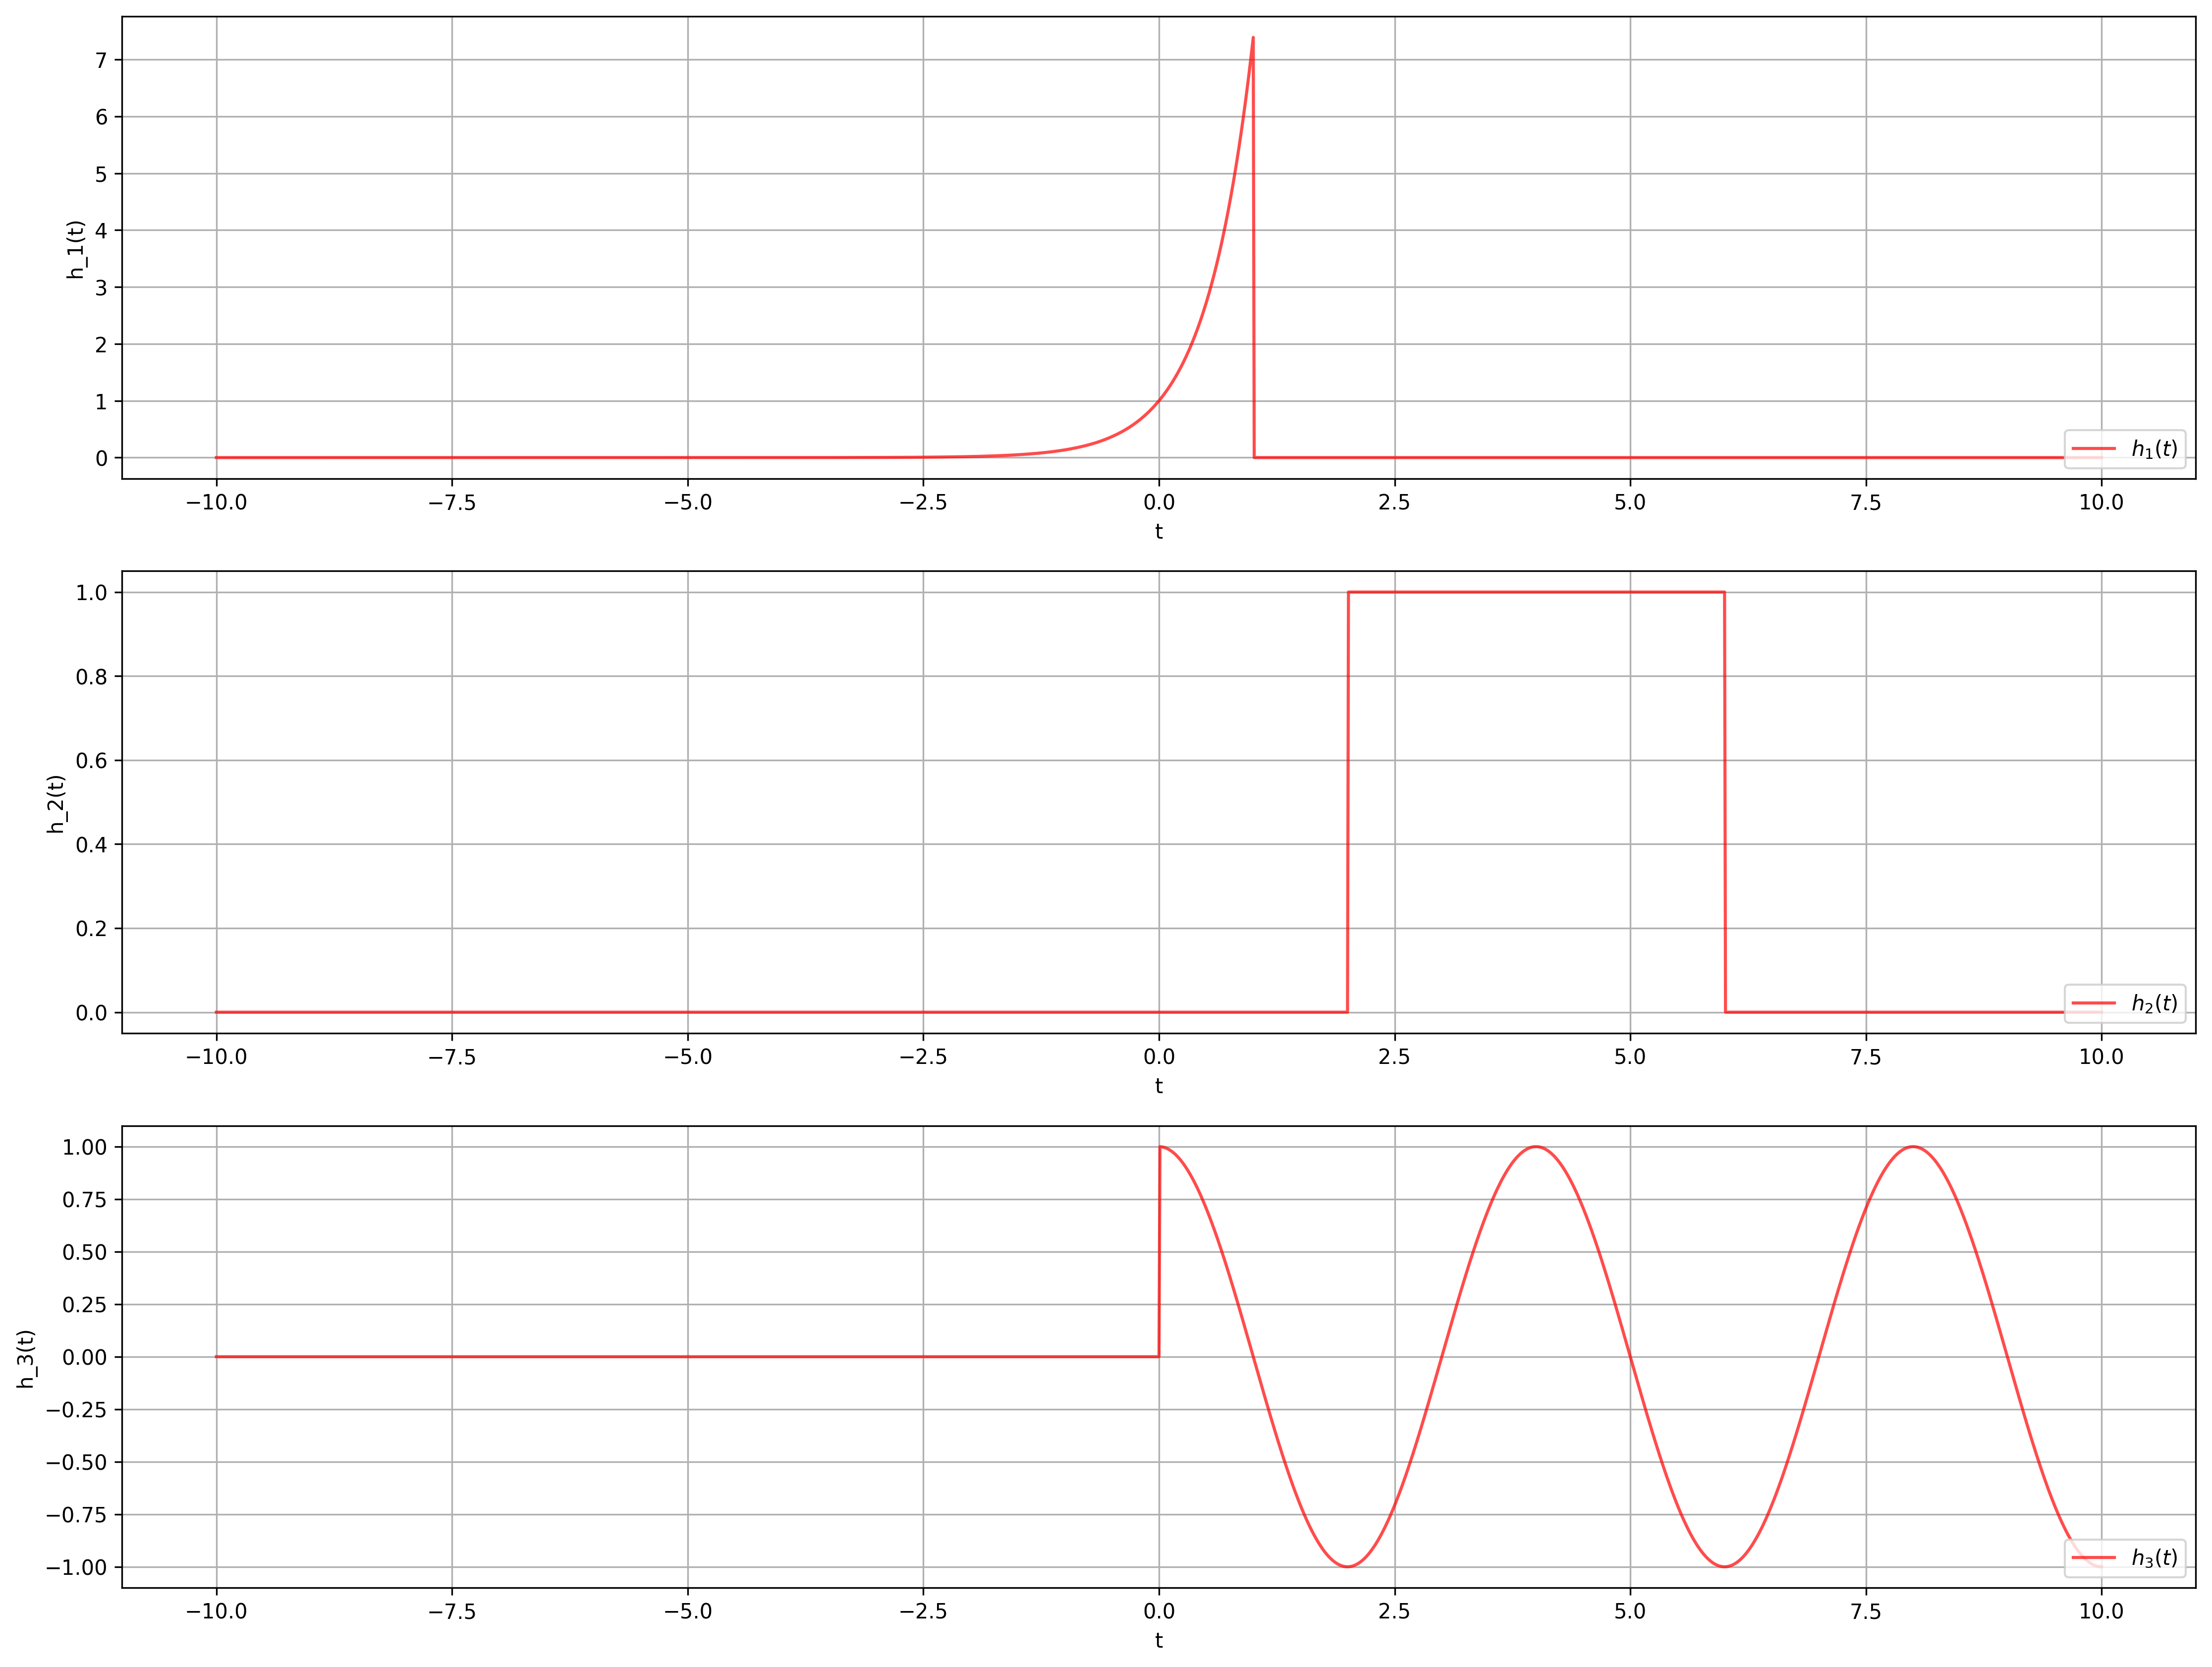

In [4]:
step_size = 0.01
t = np.arange(-10, 10 + step_size, step_size)
freq = 0.250
create_plot([t, t, t],
            [(h_1(t), ), (h_2(t), ), (h_3(t, freq), )],
            ['t', 't', 't'],
            ["h_1(t)", "h_2(t)", "h_3(t)"],
            [("$h_1(t)$", ), ("$h_2(t)$", "val"), ("$h_3(t)$", )], 3)

## Part 2
Implementing the convolution of the above-defined functions is shown below. For $h_3(t)$, we'll use a $f_0$ of .25 Hz. 
### Hand-Calculated Convolution
$$h_1*u(t)=\int_{-\infty}^{\infty} u(t-\tau)e^{2\tau}u(1-\tau)d\tau$$
We know that $u(t-\tau)$ = 0 if $\tau >t$ and that $u(1-\tau)=0$ if $\tau > 1$. This gives two different integral boundaries. If $t \leq 1$ then we can simplify the equation as follows:
$$\int_{-\infty}^{t} e^{2\tau}d\tau$$
$$\frac{1}{2}(e^{2t}-0)u(1-t)$$
$$\frac{1}{2}e^{2t}\cdot u(1-t)$$
The second integral, if $t \geq 1$ simplifies as follows:
$$\int_{-\infty}^{1} e^{2\tau} d\tau$$
$$\frac{1}{2}e^2\cdot u(t-1)$$
Thus, the convolution is:
$$e^{2t}\cdot u(1-t) * u(t) = \frac{1}{2}e^{2t}\cdot u(1-t)+\frac{1}{2}e^2 \cdot u(t-1)$$
***
$$h_2 * u(t) = \int_{-\infty}^{\infty} u(t-\tau)(u(\tau-2)-u(\tau-6))d\tau$$
We know that $u(t-\tau)=0$ if $\tau>t$, $u(\tau-2)=0$ if $\tau<2$, and that $u(\tau-6)=0$ if $\tau<6$. This gives us two cases. Case one, where $2 \leq t \leq 6$, evaluates to the following:
$$\int_{2}^{t} 1\cdot(1-0)d\tau$$
$$(t-2)\cdot u(t-2)\cdot u(6-t)$$
Case two, where $t \geq 6$, evauluates to this:
$$\int_{2}^{6} 1\cdot(1-0)d\tau$$
$$4\cdot u(t-6)$$
Thus, the convolution is:
$$(u(t-2)-u(t-6)) * u(t) = (t-2)\cdot u(t-2) \cdot u(6-t)-4\cdot u(t-6)$$
***
$$h_3 * u(t) = \int_{-\infty}^{\infty} u(t-\tau)cos(0.5 \pi \tau) u(\tau)d\tau$$
It is obvious that $u(\tau)=0$ if $\tau < 0$, and that $u(t-\tau)=0$ if $\tau > t$, changing our bounds of integration to:
$$\int_{0}^{t} cos(0.5 \pi \tau)d\tau$$
$$\frac{1}{0.5 \pi}sin(0.5\pi t)\cdot u(t)$$
Thus the convolution is:
$$(cos(0.5\pi t)\cdot u(t)) * u(t) = \frac{1}{0.5 \pi}sin(0.5\pi t)\cdot u(t)$$

### Computer-Convolution

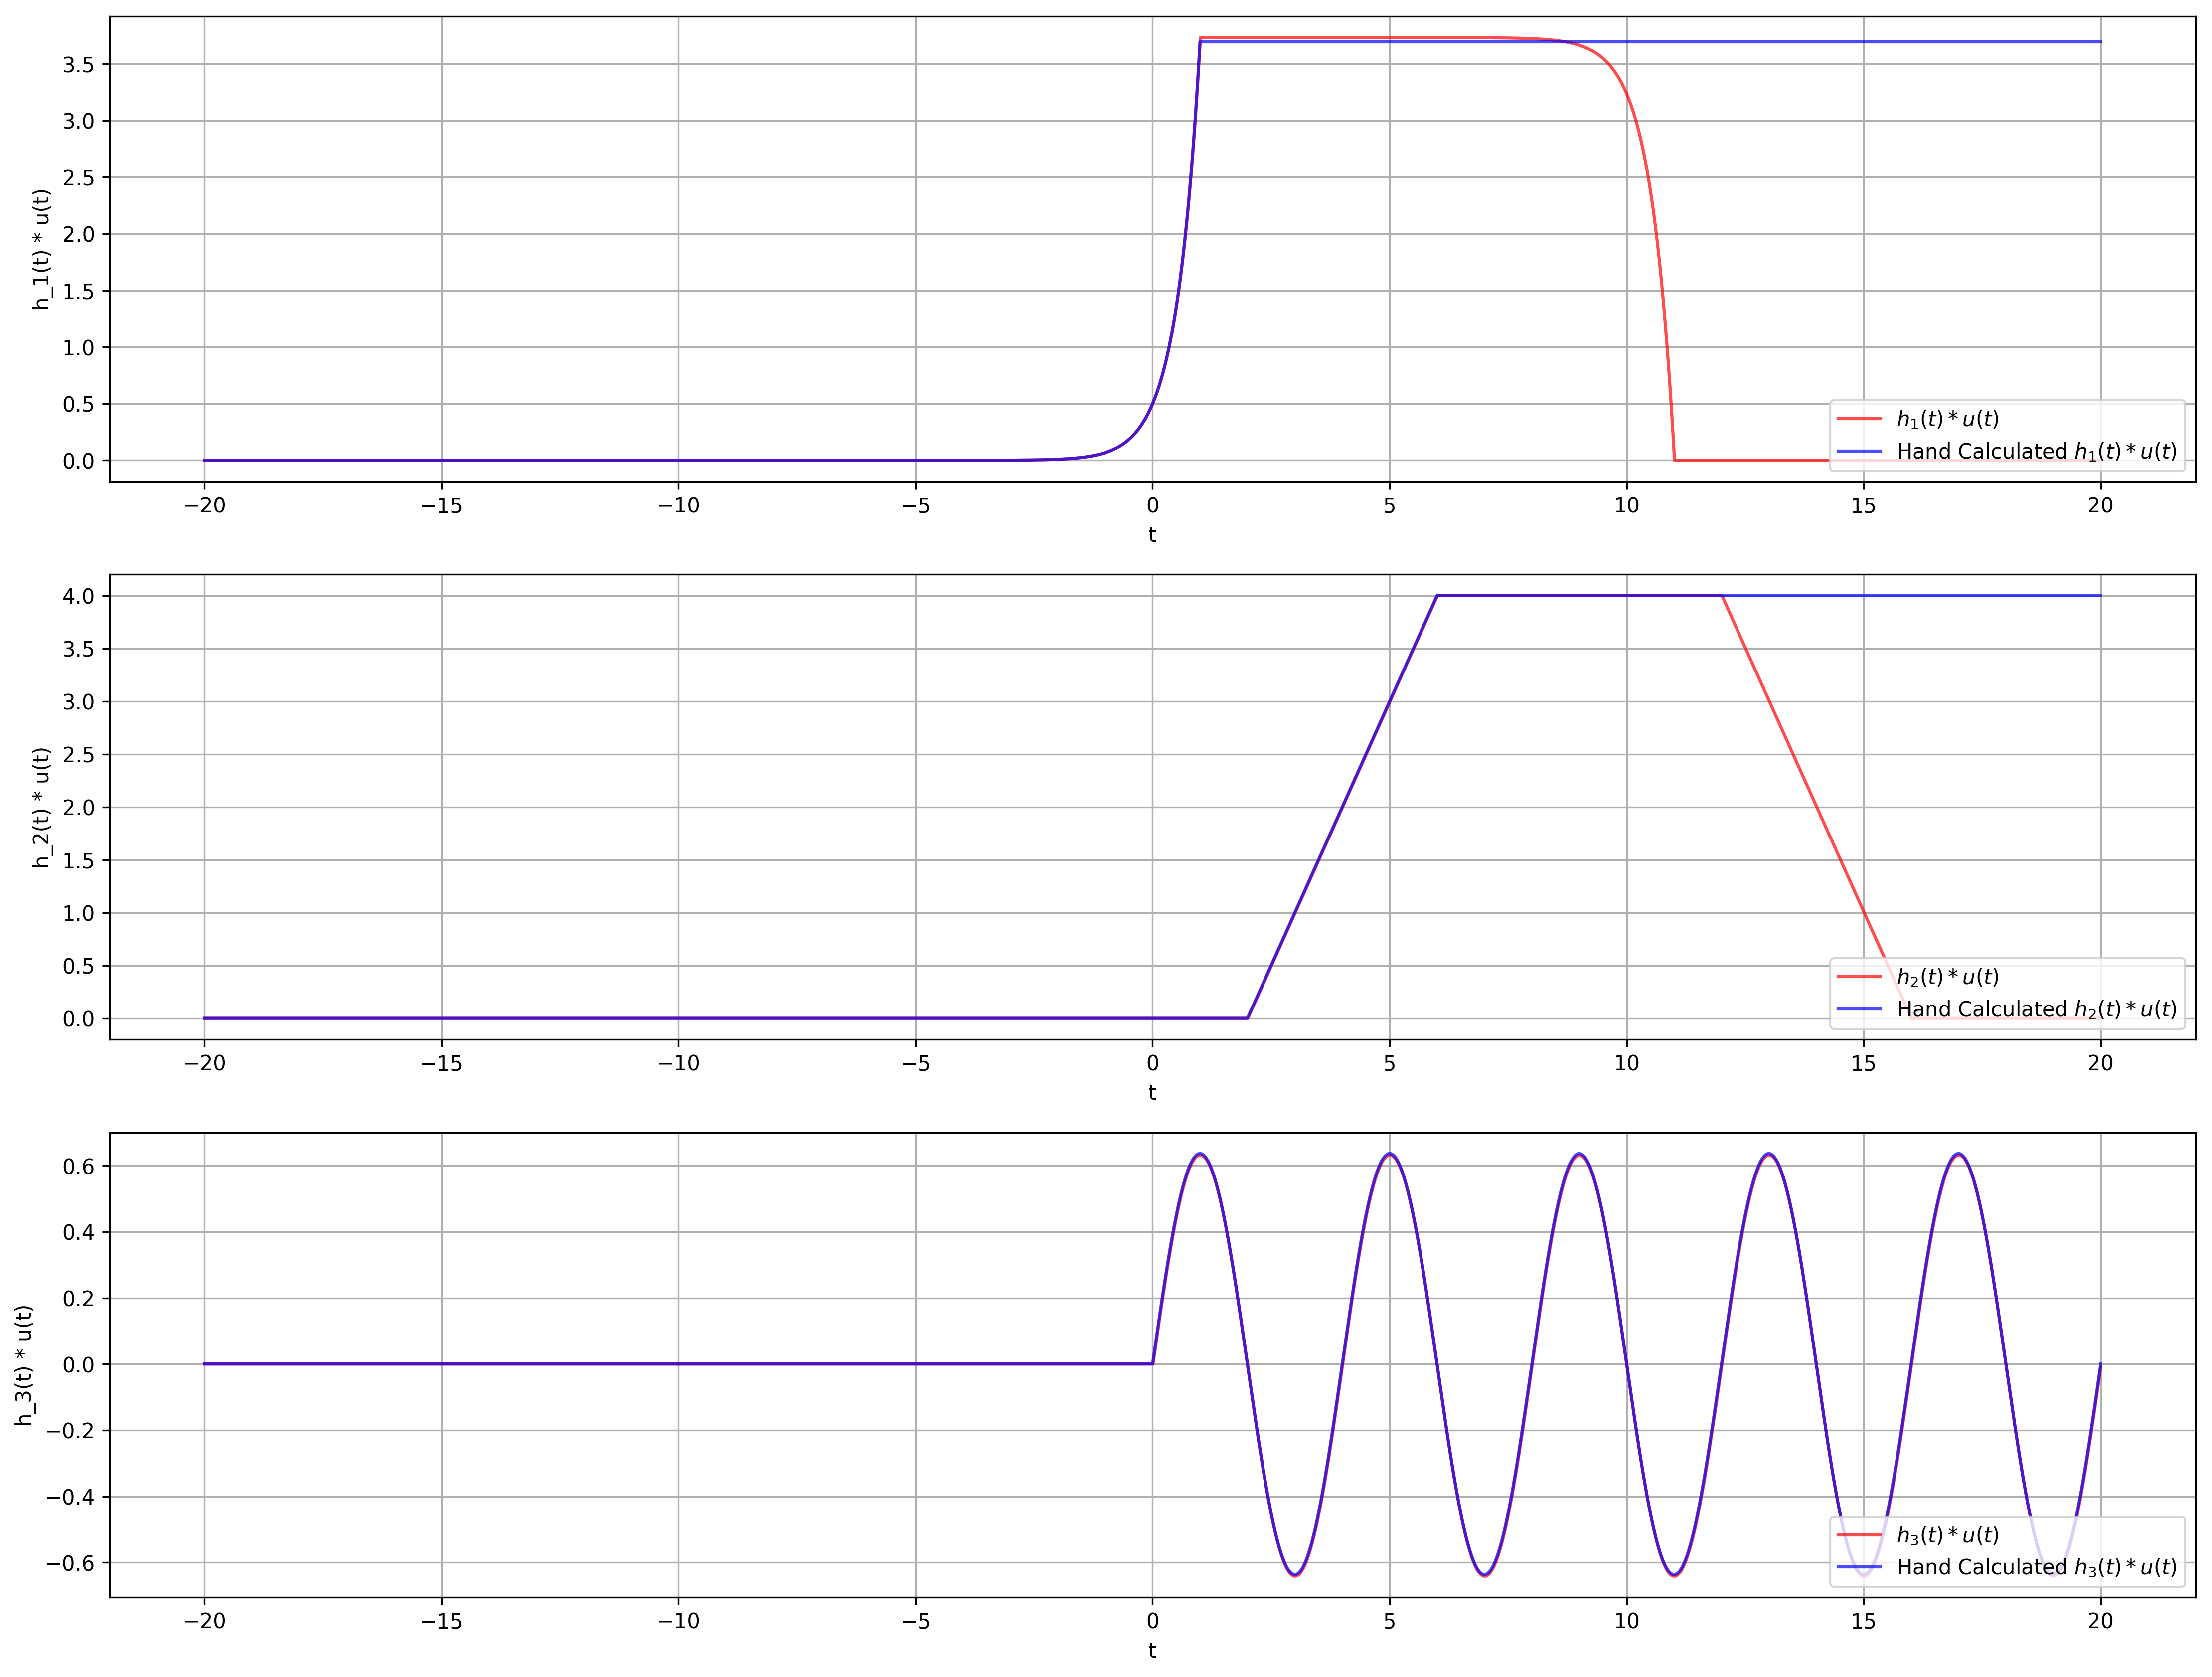

In [5]:
def h_1_hand(x_vals):
    return (0.5 * np.exp(2 * x_vals) * u(-x_vals, -1) + 0.5 * np.exp(2) * u(x_vals, 1))

def h_2_hand(x_vals):
    return ((x_vals - 2) * u(x_vals, 2) * u(-x_vals, -6) + 4 * u(x_vals, 6))

def h_3_hand(x_vals):
    return (1 / (0.5 * np.pi) * np.sin(0.5 * np.pi * x_vals) * u(x_vals))

t_conv = np.arange(t[0]*2, t[-1]*2 + step_size, step_size)
create_plot([t_conv, t_conv, t_conv],
            [(conv(u(t), h_1(t), 1 / step_size), h_1_hand(t_conv)),
             (conv(u(t), h_2(t), 1 / step_size), h_2_hand(t_conv)),
             (conv(u(t), h_3(t, freq), 1 / step_size), h_3_hand(t_conv))],
            ['t', 't', 't'],
            ["h_1(t) * u(t)", "h_2(t) * u(t)", "h_3(t) * u(t)"],
            [("$h_1(t)*u(t)$", "Hand Calculated $h_1(t)*u(t)$"),
             ("$h_2(t)*u(t)$", "Hand Calculated $h_2(t)*u(t)$"),
             ("$h_3(t) * u(t)$", "Hand Calculated $h_3(t) * u(t)$")], 3)

## Conclusion
This results of this lab were quite suprising. The discrepancies between the hand-convolution and the computer-calculated convolution were unexpected. Realizing that _technically_ our computer-calculation performs a discrete convolution makes the reason for these discrepancies apparant. When we arithmetically perform the convolution of the two signals, we're operating on the signals as if they continue and exist for all of time. On the other hand, the computer only operates on the signals for the provided _range_ (-10 to 10, in this case), resulting in the appearance that the step-function is actually a pulse (and the output graphs reflect this).